## DAST Project

The following notebook is a modified version of the original notebook I used for a Machine-Learning Lecture. The Codebook contains a lot of descriptions required for the previous task. I just added that the data is now taken from DBRepo instead of a local csv file.

*DISCLAIMER: I accidently had to use my personal e-mail for DBRepo since I forgot the password for the account I setup with my student mail. All my uploads are made under "thimon.pelka@gmail.com" and the username is "e12123690". The upload to TUWRD was done with my normal student-account* 

#### First we have to import all our dependencies and set up the logging

In [1]:
import numpy as np
from pandas import read_csv
import pandas as pd
from scipy.fft import fft
import matplotlib.pyplot as plt
import pickle
from dotenv import load_dotenv
import os
from datetime import datetime
import json

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

import requests

# New import for DAST!
from dbrepo.RestClient import RestClient

load_dotenv()

# Setup DBRepo Client
dbrepo_username = os.getenv('dbrepo_username')
dbrepo_password = os.getenv('dbrepo_password')
tuwrd_token = os.getenv('tuwrd_token')

client = RestClient(endpoint="https://test.dbrepo.tuwien.ac.at", username=dbrepo_username, password=dbrepo_password)

#### Next we define our necessary helper function. These will help us in the next step when we read in and re-format the given csv files.

First we define a function impute_column which overwrites the missing values in a given column with a given value. This function is taken directly from the exercise.

In [29]:
def impute_column(df, column_name, imp_value):
    """
    Takes the name of a column and a value to impute missing values with
    and overwrites the missing values of said column. This should be
    done using the .fillna() method, as this automatically overwrites
    the values in the underlying data set.

    Parameters
    ----------
    df : DataFrame
        our data set
    column_name : str
        the name of the column you want to handle
    imp_value
        the value you want to use to overwrite missing values with
    """
    # YOUR CODE HERE
    df[column_name] = df[column_name].fillna(imp_value)

We also define a min_max_scale function which scales an array to a given lower and upper bound. This is also taken directly from the exercise.

In [30]:
def min_max_scale(x, a, b):
    """
    Parameters
    ----------
    x : np.array
        data vector
    a : int
        lower bound of the min-max range
    b : int
        upper bound of the min-max range

    Returns
    -------
    x : np.array
        scaled data vector
    """
    # YOUR CODE HERE
    min = np.min(x)
    max = np.max(x)

    res = a + (((x - min) * (b - a)) / (max - min))

    return res

As a last function we define extract_fft_features. This function extracts the first few components of the absolute value of the FFT of a given array.

In [31]:
def extract_fft_features(values, num_components=5):
    """
    Extracts the first few components of the absolute value of the FFT of a given array.

    Parameters:
    values (array-like): The input array of values to compute the FFT.
    num_components (int, optional): The number of FFT components to extract. Defaults to 5.

    Returns:
    numpy.ndarray: An array containing the first `num_components` absolute values of the FFT.
    """
    fft_features = np.abs(fft(values))[:num_components]
    return fft_features


Now we get to the probably most important function. This function loads a given csv file and pre-processes all the data. Since it took me a while to get good results I did quite a lot of pre-processing steps. First I imputed empty values, min_max_scaled almost all rows and then I grouped the data by their ids. Then I went through all the columns for each dataset and calculate a multitude of features like the mean, std, min, max, etc. I saved all these features and added them to the dataframe.

In [32]:
def loadData(identifier_id):
    # Read in data
    # In the original version we would read the data from a csv. Now we use the DB Repo client
    #data = read_csv(name)
    data = client.get_identifier_data(identifier_id=identifier_id)

    # impute window_id
    impute_column(data, "window_id", -1)

    # iterate over numerical columns and impute them# Try converting all columns to numeric, non-convertible entries become NaN
    data = data.apply(pd.to_numeric, errors="coerce")

    # Now select numeric columns again after coercion
    numeric_columns = data.select_dtypes(include=["number"]).columns
    for c in numeric_columns:
        # val = np.min(data[c])
        impute_column(data, c, -1)


    # iterate over all columns and min_max_scale them, but skip id and
    # column label as we do not want to manipulate them
    for c in numeric_columns:
        if c in ["id", "label"]:
            #print("Skipping column: " + c)
            continue

        data[c] = min_max_scale(data[c], 0, 1)

    # Extract temporal features for each sequence
    features_per_sequence = []

    # Group elements by id and iterate over each id
    for id_group in data.groupby("id"):

        sequence = id_group[1].copy()
        sequence["window_id"] = pd.to_numeric(sequence["window_id"], errors="coerce")
        # Setup Sequencing
        sequence = sequence.sort_values("window_id")
        sequence_features = {"id": id_group[0]}

        # Original features
        for col in numeric_columns:
            if col not in ["id", "label", "window_id"]:
                values = sequence[col].values

                # Base statistical features
                sequence_features.update({
                    f"{col}_mean": np.mean(values),
                    f"{col}_std": np.std(values),
                    f"{col}_max": np.max(values),
                    f"{col}_min": np.min(values),
                    f"{col}_median": np.median(values),
                    f"{col}_last_value": values[-1],
                    f"{col}_value_change": values[-1] - values[0],
                })

                # FFT features
                fft_features = extract_fft_features(values)
                for i, feat in enumerate(fft_features):
                    sequence_features[f"{col}_fft_{i}"] = feat

                # Non-linear transformations
                sequence_features[f"{col}_squared"] = np.mean(values ** 2)
                sequence_features[f"{col}_cubed"] = np.mean(values ** 3)

        if "label" in sequence:
            sequence_features["label"] = sequence["label"].iloc[0]

        features_per_sequence.append(sequence_features)

    # Create pandas df out of extracted features
    result_df = pd.DataFrame(features_per_sequence)

    # if label exists in the pandas df (= we have a training set) then extract features...
    if "label" in result_df.columns:
        labels = result_df["label"]
        features = result_df.drop(columns=["label"])
        return features, labels

    # ... else just return the df
    return result_df, []

Since we want to use Hyperparameter tuning we have to set up our Grid Search. I did this for both a random forest classifier as well as a decision tree classifier

In [33]:
# Define parameter grid for Random Forest Classifier
param_grid_rfc = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize GridSearchCV for Random Forest Classifier
grid_search_rfc = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid_rfc,
    cv=5,
    n_jobs=-1,
    verbose=2
)

# Define parameter grid for Decision Tree Classifier
param_grid_dtc = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize GridSearchCV for Decision Tree Classifier
grid_search_dtc = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=42),
    param_grid=param_grid_dtc,
    cv=5,
    n_jobs=-1,
    verbose=2
)

Now we load the data and split the training data into a training and a test set

In [34]:
data_train_features, data_train_labels = loadData("f8c073c6-9bd9-4cdf-965f-6f0733c91b86")

# Split the training data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    data_train_features, data_train_labels, test_size=0.2, random_state=42
)

print("Data loaded and split.")

Data loaded and split.


Next we train our models and test their accuracy. We will print the accuracy of the models and display the confusion matrix using matplotlib. This is first done for a Random Forest Classifer Model...

Fitting 5 folds for each of 108 candidates, totalling 540 fits


c:\Users\thimo\.conda\envs\opop-iter-3\Lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


Validation Accuracy Random Forest: 95.24%


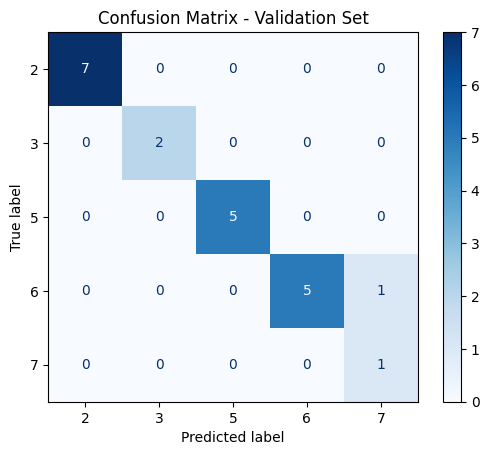

In [37]:
# Train the random forest model
grid_search_rfc.fit(X_train, y_train)

# Get best estimator
best_model_rfc = grid_search_rfc.best_estimator_

# Save the model to disk
with open('best_model_random_forest_classifier.pkl', 'wb') as file:
  pickle.dump(best_model_rfc, file)

# Evaluate on the validation set
y_val_pred_rfc = best_model_rfc.predict(X_val)

# Calculate Accuracy
accuracy_rfc = accuracy_score(y_val, y_val_pred_rfc)
print(f"Validation Accuracy Random Forest: {accuracy_rfc:.2%}")

# Compute the confusion matrix
conf_matrix_rfc = confusion_matrix(y_val, y_val_pred_rfc)

# Display the confusion matrix
# Get only the labels present in the validation data
labels_in_val = np.unique(np.concatenate((y_val, y_val_pred_rfc)))

disp_rfc = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_rfc, display_labels=labels_in_val)
disp_rfc.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Validation Set")

plt.savefig("confusion_matrix_random_forest_classifier.png", dpi=300, bbox_inches='tight')

plt.show()

# Print classification report
report = classification_report(y_val, y_val_pred_rfc)

... and a Decision Tree Classifier Model.

Fitting 5 folds for each of 72 candidates, totalling 360 fits


c:\Users\thimo\.conda\envs\opop-iter-3\Lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


Validation Accuracy Decision Tree: 76.19%


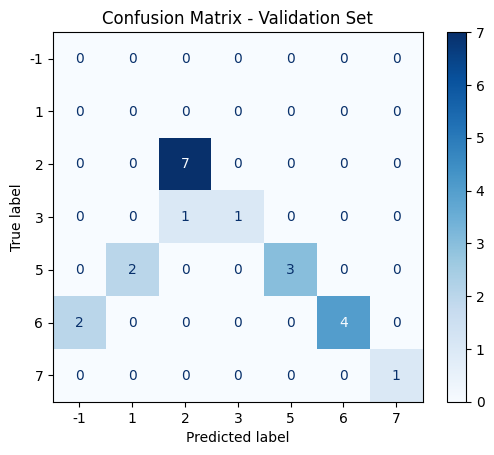

In [38]:
# Train the decision tree model
grid_search_dtc.fit(X_train, y_train)

# Get best estimator
best_model_dtc = grid_search_dtc.best_estimator_

# Save the model to disk
with open('best_model_decision_tree_classifier.pkl', 'wb') as file:
  pickle.dump(best_model_rfc, file)

# Evaluate on the validation set
y_val_pred_dtc = best_model_dtc.predict(X_val)

# Calculate Accuracy
accuracy_dtc = accuracy_score(y_val, y_val_pred_dtc)
print(f"Validation Accuracy Decision Tree: {accuracy_dtc:.2%}")

# Compute the confusion matrix
conf_matrix_dtc = confusion_matrix(y_val, y_val_pred_dtc)

# Display the confusion matrix
disp_dtc = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_dtc, display_labels=best_model_dtc.classes_)
disp_dtc.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Validation Set")

plt.savefig("confusion_matrix_decision_tree_classifier.png", dpi=300, bbox_inches='tight')

plt.show()

# Print classification report
report = classification_report(y_val, y_val_pred_dtc, zero_division=0)

As we see the Random Forest Model performs way better. For this reason we will continue using it for the competition data set. In the following code we use the model to predict the test data set for the competition and save the results in a .csv file we can then submit

In [27]:
# Load test data
data_test_features, _ = loadData("8941f010-de28-40b4-94e1-72fa6be1156f")

# Get prediction
y_test_pred = best_model_rfc.predict(data_test_features)

# Setup output data
data_test_features["label"] = y_test_pred

# Create a copy of the desired columns to avoid SettingWithCopyWarning
output = data_test_features[["id", "label"]].copy()

# Rename 'id' column to 'ID' to conform to submission format
output.rename(columns={'id': 'ID'}, inplace=True)

filename = "rocketskillshots_test_predicted.csv"

# Save Data
output.to_csv(filename, index=False)

print("Script finished. Saved data to " + filename)

Script finished. Saved data to rocketskillshots_test_predicted.csv


Upload results to TUWRD.

Create a new draft:

In [ ]:
url = "https://test.researchdata.tuwien.at/api/records"

headers = {
    "Authorization": f"Bearer {tuwrd_token}",
    "Content-Type": "application/json"
}
data = {
    "metadata": {
        "creators": [
            {
                "person_or_org": {
                    "family_name": "Pelka",
                    "given_name": "Thimon",
                    "type": "personal",
                }
            }
        ],
        "publication_date": datetime.today().strftime('%Y-%m-%d'),
        "publisher": "TU Wien",
        "resource_type": {"id": "dataset"},
        "title": "Rocket League Skillshot Prediction",
        "description": "Output of a Machine-Learning task which predicts Rocket League skillshots based on the last 30 frames before a goal was scored."
    },
    "files": {"enabled": True},
}

response = requests.post(url, json=data, headers=headers)

pretty_json = json.dumps(response.json(), indent=4)

if "status" in response.json() and response.json()["status"] == "draft":
    print(f"Succesfully created draft at TUWRD. Draft has id {response.json()["id"]}")
else:
    print(f"An error occured during creating of draft at TUWRD. See the following response:\n", pretty_json)

id = response.json()["id"]


Succesfully created draft at TUWRD. Draft has id m0bmw-8fk56


Upload Files to Draft

In [28]:
def upload_file(filename, id):
    # Initialize fileupload
    response = initialize_file_upload(filename, id)

    if ("status" in response and response["status"] != 'completed'):
        print(f"Problem during initialization of upload of {filename}:\n", json.dumps(response, indent=4))
        return

    # Upload file
    response = upload_file_content(filename, id)

    if ("status" in response and response["status"] != 'pending'):
        print(f"Problem during uploading of file content of {filename}:\n", json.dumps(response, indent=4))
        return

    # Commit draft file upload
    response = commit_draft_file_upload(filename, id)

    if ("status" in response and response["status"] != 'completed'):
        print(f"Problem during committing of draft file for {filename}:\n", json.dumps(response, indent=4))
        return

    print(f"Succesfully uploaded {filename}")

def commit_draft_file_upload(filename, id):
    url = f"https://test.researchdata.tuwien.at/api/records/{id}/draft/files/{filename}/commit"
    headers = {
        "Authorization": f"Bearer {tuwrd_token}",
    }

    response = requests.post(url, headers=headers)

    return response.json()


def upload_file_content(filename, id):
    url = f"https://test.researchdata.tuwien.at/api/records/{id}/draft/files/{filename}/content"
    headers = {
        "Authorization": f"Bearer {tuwrd_token}",
        "Content-Type": "application/octet-stream"
    }

    with open(f"{filename}", "rb") as file_data:
        response = requests.put(url, headers=headers, data=file_data)

    return response.json()


def initialize_file_upload(filename, id):
    url = f"https://test.researchdata.tuwien.at/api/records/{id}/draft/files"

    headers = {
        "Authorization": f"Bearer {tuwrd_token}",
        "Content-Type": "application/json"
    }
    data = [
        {
            "key": f"{filename}"
        }
    ]

    response = requests.post(url, json=data, headers=headers)

    return response.json()


files_to_upload = [
    "best_model_random_forest_classifier.pkl",
    "best_model_decision_tree_classifier.pkl",
    "confusion_matrix_random_forest_classifier.png",
    "confusion_matrix_decision_tree_classifier.png",
    "rocketskillshots_test_predicted.csv"
]

for file in files_to_upload:
    upload_file(file, id)

Succesfully uploaded best_model_random_forest_classifier.pkl
Succesfully uploaded best_model_decision_tree_classifier.pkl
Succesfully uploaded confusion_matrix_random_forest_classifier.png
Succesfully uploaded confusion_matrix_decision_tree_classifier.png
Succesfully uploaded rocketskillshots_test_predicted.csv


Updating the remaining metadata is (according to the task-description) supposed/allowed to be done using the graphical user interface of TUWRD. Due to this condition the notebook ends here as everything its supposed to do is completed.